In [ ]:
%cd /content/drive/MyDrive/Colab/islampy/

/content/drive/MyDrive/Colab/islampy


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load Data

In [ ]:
data = pd.read_csv('data/converted.csv')

In [ ]:
data.head()

,name,english,muslim
0,कृष्णमनी झा,krishnamani jha,0.0
1,पति परमानन्द मंडल,pathi paramananda mandal,0.0
2,डोमन मंडल,doman mandal,0.0
3,गुनानन्द झा,gunanda jha,0.0
4,मुकुन्द लाल झा,mukunda lal jha,0.0


In [ ]:
data.shape

(2325305, 3)

In [ ]:
# Drop nan values
data = data.dropna(axis=0)

In [ ]:
# Drop any names that are more than 50 chars.
data = data.drop(data[data.english.str.len() > 50].index)

In [ ]:
data['english'].str.len().max()

50

In [ ]:
data.shape

(2300828, 3)

In [ ]:
data.groupby('muslim').count()

,name,english
muslim,,
0.0,1974301,1974301
1.0,259939,259939
9.0,66588,66588


In [ ]:
data[data['muslim'] == 9.0]

,name,english,muslim
131,ज्ञानी साहु,gnani sahu,9.0
220,जसरथ साह,jasrath sah,9.0
223,नसरत साह,nasarat sah,9.0
463,ठीठरु साह,thitharu sah,9.0
514,बगघु साह,bagaghu sah,9.0
...,...,...,...
2226175,राजकुमार साव वगैरह,rajkumar sawagarh,9.0
2226196,राम कुमार साव वगैरह,ram kumar sawagairah,9.0
2226223,"मीना देबी,",meena debi,9.0
2226284,दशरथ मोदी व दीनानाथ मोदी,dasarath modi v deenanath v d,9.0


In [ ]:
data = data.drop(data[data['muslim'] == 9.0].index)

In [ ]:
data.groupby('muslim').count()

,name,english
muslim,,
0.0,1974301,1974301
1.0,259939,259939


In [ ]:
X = data['english'].values
y = data['muslim'].values

# Split Data

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3)

In [ ]:
X_train.size

1563968

In [ ]:
X_rem.size

670272

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

In [ ]:
X_val.size

335136

In [ ]:
X_test.size

335136

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

# Creating Dataset

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1500000

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
text_batch, label_batch = next(iter(train_dataset))
first_name, first_label = text_batch[0], label_batch[0]
print("Name", first_name)
print("Label", first_label)

Name tf.Tensor(b'rama', shape=(), dtype=string)
Label tf.Tensor([1. 0.], shape=(2,), dtype=float32)


# Vectorization

In [ ]:
max_features = 300000
sequence_length = 50

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
print("Vectorized data", vectorize_text(first_name, first_label))

Vectorized data (<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[288,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 0.], dtype=float32)>)


In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[277608])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[179])
print(f'Vocabulary size: {len(vectorize_layer.get_vocabulary())}')

1287 --->  janis
 313 --->  lakshmi
Vocabulary size: 300000


In [ ]:
train_ds = train_dataset.map(vectorize_text)
val_ds = val_dataset.map(vectorize_text)
test_ds = test_dataset.map(vectorize_text)

In [ ]:
# For performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model

In [ ]:
embedding_dim = 64
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features + 1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation='softmax')])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          19200064  
                                                                 
 dropout_6 (Dropout)         (None, None, 64)          0         
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 19,200,194
Trainable params: 19,200,194
Non-trainable params: 0
__________________________________________

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


24437/24437 [==============================] - 133s 5ms/step - loss: 0.1045 - accuracy: 0.9626 - val_loss: 0.0793 - val_accuracy: 0.9735
Epoch 2/10
24437/24437 [==============================] - 130s 5ms/step - loss: 0.0750 - accuracy: 0.9739 - val_loss: 0.0766 - val_accuracy: 0.9752
Epoch 3/10
24437/24437 [==============================] - 129s 5ms/step - loss: 0.0714 - accuracy: 0.9754 - val_loss: 0.0753 - val_accuracy: 0.9755
Epoch 4/10
24437/24437 [==============================] - 129s 5ms/step - loss: 0.0692 - accuracy: 0.9763 - val_loss: 0.0748 - val_accuracy: 0.9757
Epoch 5/10
24437/24437 [==============================] - 130s 5ms/step - loss: 0.0678 - accuracy: 0.9769 - val_loss: 0.0744 - val_accuracy: 0.9759
Epoch 6/10
24437/24437 [==============================] - 130s 5ms/step - loss: 0.0667 - accuracy: 0.9772 - val_loss: 0.0742 - val_accuracy: 0.9760
Epoch 7/10
24437/24437 [==============================] - 130s 5ms/step - loss: 0.0658 - accuracy: 0.9776 - val_loss: 0.074

# Evaluate

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

5237/5237 [==============================] - 9s 2ms/step - loss: 0.0724 - accuracy: 0.9764
Loss:  0.07242037355899811
Accuracy:  0.976388692855835


# Plot

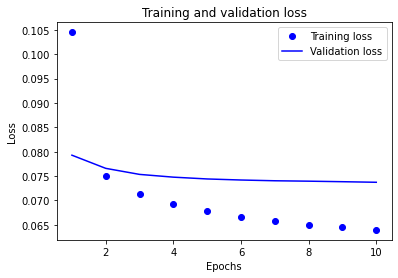

In [ ]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

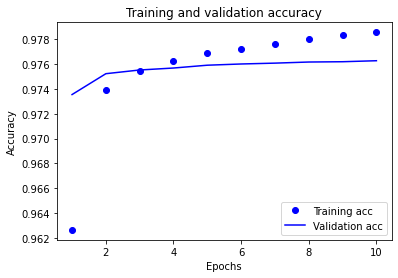

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Save Model

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model
])

export_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(test_dataset)
print(accuracy)

5237/5237 [==============================] - 12s 2ms/step - loss: 0.0724 - accuracy: 0.9764
0.976388692855835


# Inference

In [ ]:
examples = [
  "Shah Rukh Khan",
  "Amitabh Bachchan",
  "Abdul Rashid Salim Salman Khan"
]

results = export_model.predict(examples)

In [ ]:
results

array([[4.6475761e-02, 9.5352429e-01],
       [9.0414155e-01, 9.5858440e-02],
       [9.6635245e-07, 9.9999905e-01]], dtype=float32)

In [ ]:
probs = tf.nn.softmax(results)

In [ ]:
probs

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.28760418, 0.71239585],
       [0.6917435 , 0.30825648],
       [0.26894182, 0.73105824]], dtype=float32)>

In [ ]:
res_args = tf.argmax(results, 1)

In [ ]:
classes= ['not-muslim', 'muslim']

In [ ]:
for i in range(0, len(examples)):
  print(f"{examples[i]} is of {classes[res_args[i]]} with muslim probability of {probs[i][1] * 100}%")

Shah Rukh Khan is of muslim with muslim probability of 71.23958587646484%
Amitabh Bachchan is of not-muslim with muslim probability of 30.825647354125977%
Abdul Rashid Salim Salman Khan is of muslim with muslim probability of 73.10582733154297%


# Export model

In [ ]:
export_model.save('saved_model/eng_model_softmax')

INFO:tensorflow:Assets written to: saved_model/eng_model_softmax/assets


# Load Model

In [ ]:
new_model = tf.keras.models.load_model('saved_model/eng_model_softmax')

In [ ]:
new_results = new_model.predict(examples)

In [ ]:
res_args = tf.argmax(new_results, 1)

In [ ]:
res_args

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 0, 1])>

In [ ]:
new_probs = tf.nn.softmax(new_results)

In [ ]:
new_probs

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.26894143, 0.73105854],
       [0.73105854, 0.26894143],
       [0.26894143, 0.73105854]], dtype=float32)>

In [ ]:
for i in range(0, len(examples)):
  print(f"{examples[i]} is of {classes[res_args[i]]} with muslim probability of {new_probs[i][1] * 100}%")

Shah Rukh Khan is of muslim with muslim probability of 73.10585021972656%
Amitabh Bachchan is of not-muslim with muslim probability of 26.89414405822754%
Abdul Rashid Salim Salman Khan is of muslim with muslim probability of 73.10585021972656%
